# STOP!!! READ THIS FIRST
You should only look at these solutions once you think you have working solutions of your own :).

## Section 4 - Uncertainties in best-fit parameters
This section details how you can estimate uncertainties on your best fit parameters. For the line example we have the slope $b$ and the intercept $m$, and we want to know $\sigma_b$ and $\sigma_m$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
plt.rc("font", size=24)
plt.rc("errorbar", capsize=3) #Ignore

<Container object of 3 artists>

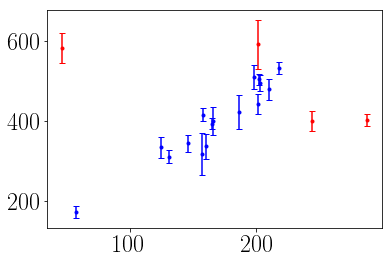

In [2]:
#Get the data. We only want x, y and the error on y
_, x_all, y_all, sigy_all, _, _ = np.genfromtxt("data.txt", unpack=True, delimiter='&', skip_header=1)
N_data = len(x_all)
def get_all_data():
    return x_all, y_all, sigy_all

def get_good_data():
    #Points 4 onward
    return x_all[4:], y_all[4:], sigy_all[4:]

def get_bad_data():
    #Points 0 through 3
    return x_all[:4], y_all[:4], sigy_all[:4]
x, y, sigy = get_good_data()
plt.errorbar(x, y, sigy, c='b', ls='', marker='.')
x, y, sigy = get_bad_data()
plt.errorbar(x, y, sigy, c='r', ls='', marker='.')

## Exercise 8: jackknife and bootstrap error
We will now estimate the variance on the slope $\sigma_m^2$ using two methods: the jackknife method and the bootstrap method. As a reminder, the reason for doing this is that these methods can get around the issue of having *bad data*, or the first four points.

In [3]:
#Write a function that takes some x, y, sigy and spits out a b, m
def get_bm(x, y, sigy):
    C = np.diag(sigy**2)
    Cinv = np.linalg.inv(C)
    A = np.vstack((np.ones_like(x), x)).T
    cov = np.linalg.inv(np.dot(A.T, np.dot(Cinv, A)))
    b, m = np.dot(cov, np.dot(A.T, np.dot(Cinv, y)))
    return b, m

In [4]:
#Get b_true and m_true
x, y, sigy = get_all_data()
b_true, m_true = get_bm(x, y, sigy)

#First do bootstrap
np.random.seed(123456)
M = 1000
data = np.array((x, y, sigy)).T
inds = np.arange(N_data)
inds_boot = np.random.choice(inds, size=(M, N_data), replace=True)
bs_boot = np.zeros(M)
ms_boot = np.zeros(M)
for i in range(M):
    xi, yi, sigyi = data[inds_boot[i]].T
    bs_boot[i], ms_boot[i] = get_bm(xi, yi, sigyi)
sigm_boot = np.sqrt(1./M * np.sum((m_true-ms_boot)**2))
    
#Now do jackknife
bs_jk = np.zeros(N_data)
ms_jk = np.zeros(N_data)
data = np.array(get_all_data()).T
for i in range(N_data):
    x, y, sigy = np.delete(data, i, axis=0).T
    bs_jk[i], ms_jk[i] = get_bm(x, y, sigy)
m_ave = np.mean(ms_jk)
sigm_jk = np.sqrt((N_data-1.0)/N_data * np.sum((m_ave-ms_jk)**2))
print "m_true = ", m_true
print "Bootstrap: ", m_true, sigm_boot
print "Jackknife: ", m_ave, sigm_jk

m_true =  1.07674752417
Bootstrap:  1.07674752417 0.609632639422
Jackknife:  1.07525455382 0.874040090883


It's not really obvious which is better.

## Exercise 9: mixture-based outliers
Here we are redoing exercise 6, but without the bad outlier points, or the first four data points in our file. Then we redo it again with the uncertainies cut in half, and we should see some wacky corner plots.

In [5]:
#Write our likelihood. First step is a prior
def lnprior(params):
    m, b, Pb, Yb, Vb = params
    if m < 0 or b < -100: return -np.inf
    if Pb < 0 or Pb > 1: return -np.inf
    if Vb < 0 or Vb > 10000: return -np.inf
    if Yb < 0 or Yb > 1000: return -np.inf
    return 0

#Now a probability
def lnprob(params, x, y, sigy):
    m, b, Pb, Yb, Vb = params
    left  = (1.-Pb)/np.sqrt(2*np.pi*sigy**2)*np.exp(-0.5*(y-m*x-b)**2/sigy**2)
    right = Pb/np.sqrt(2*np.pi*(Vb+sigy**2))*np.exp(-0.5*(y-Yb)**2/(Vb+sigy**2))
    return np.sum(np.log(left+right))

#Now the total likelihood
def lnlike(params, x, y ,sigy):
    lp = lnprior(params)
    if not np.isfinite(lp): return -np.inf
    return lp + lnprob(params, x, y, sigy)

guess = [m_true, b_true, 0.2, 1.0, 2.0]

In [6]:
#Write a function that does the optimization and MCMC and returns a chain
def get_chain(x, y, sigy):
    from scipy import optimize as op
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, guess, args=(x, y, sigy), method='Powell')
    import emcee
    ndim, nwalkers = 5, 20
    nsteps = 10000
    pos = [result['x'] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, sigy))
    output = sampler.run_mcmc(pos, nsteps) #We don't use "output" at all
    return sampler.flatchain

In [7]:
#Get a chain from the regular good data and from the good data with
#smaller errorbars
x, y, sigy = get_good_data()
chain1 = get_chain(x, y, sigy)[:, :2] #Just keep m, b
chain2 = get_chain(x, y, sigy/2.)[:, :2]
print chain1.shape
print chain2.shape

/home/tom/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/tom/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0


(200000, 2)
(200000, 2)


/home/tom/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


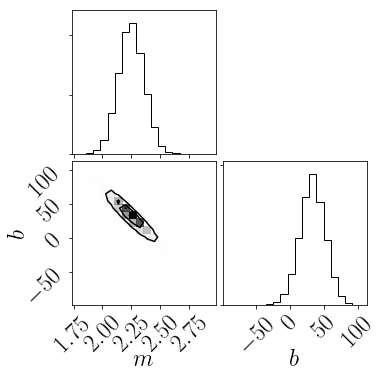

In [8]:
#Make a corner plot for each
import corner
fig = corner.corner(chain1, labels=[r"$m$", r"$b$"], plot_datapoints=False)

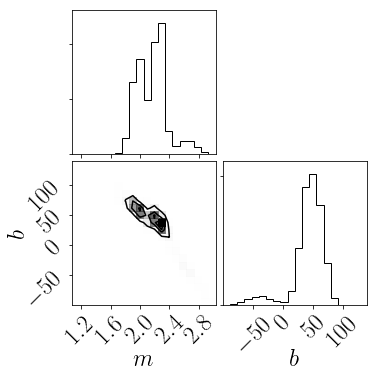

In [9]:
fig = corner.corner(chain2, labels=[r"$m$", r"$b$"], plot_datapoints=False)

In [10]:
C = np.diag(sigy**2)
Cinv = np.linalg.inv(C)
A = np.vstack((np.ones_like(x), x)).T
cov = np.linalg.inv(np.dot(A.T, np.dot(Cinv, A)))
print "basic: ", np.flip(np.sqrt(np.diagonal(cov)), 0)
print "chain1: ", np.std(chain1, 0)
print "chain2: ", np.std(chain2, 0)

basic:  [  0.10778048  18.24616675]
chain1:  [  0.1124701   19.02757328]
chain2:  [  0.20955607  28.79221843]


Critically, we see that reducing the error on our points (chain2) actually **increased** the uncertainty on our model parameters (m, b). This is why it pays to be honest about your measurement error!